In [2]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

In [284]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

## 1. Get the Data 

In [285]:
train = pd.read_csv('data/train.csv', names=['Word', 'Label'])
test = pd.read_csv('data/test.csv', names=['Word'])

## 2. Feature Engineering

In [286]:
surname_endings = [
    "ба", "уа", "ипа", "заде", "ли","лы", "оглу", "кызы", "ян", \
    "янц", "уни", "ич", "ов", "ук", "ик", "ски", "ка", "ев", "ов",\
    "огло", "пулос", "кос", "иди", "швили", "дзе", "ури", "иа",\
    "уа", "ава" "ли", "си", "ни", "ини", "те", "ис", "не", \
    "ску", "ан", "ул", "ын", "ин", "шкин", "кин", "ман", "ер"\
    "ти", "ски", "цки", "дзки", "ских", "ич", "джи", "оглу", "ин",\
    "ишин", "ко", "ук" "юк", "ун", "ний" "ный", "чай", "ий",\
    "ский", "цкий", "ская", "цкая"
]

# surname_endings = ['шкин']

for i, el in enumerate(surname_endings):
    surname_endings[i] = ".*" + surname_endings[i] + ".?.?$"

In [287]:
def countDoubles(word):
    l = [let for let in word.lower()]
    return len([(x,y) for x,y in itertools.izip(l, l[1:]) if x == y])

import re



def build_features(data):
    for i, substr in enumerate(surname_endings):
        data['has_re_end_{}'.format(i)] = data['Word'].apply(lambda x: re.match(substr, x, re.UNICODE) is not None)
    
    for i, substr in enumerate(['^Дж.*', '.*ин.?.?$', '.*ов.?.?$']):
        data['has_re_{}'.format(i)] = data['Word'].apply(lambda x: re.match(substr, x, re.UNICODE) is not None)
        
    data['Word'] = data['Word'].apply(lambda word: word.decode('utf-8'))
    data['Length'] = data['Word'].apply(lambda word: len(word))
    
    vowels = [ 'а',  'я', 'ё', 'у','е', 'о', 'э', 'ю', 'и', 'ы', 'Ё', 'У', 'Е', 'Ы','А', 'О', 'Э', 'Ю', 'И', 'Я' ]
    vowels = [let.decode('utf-8') for let in vowels]
    data['Vowels'] = data['Word'].apply(lambda word: len([letter for letter in word if letter in vowels]))
    data['Consonants'] = data['Length'] - data['Vowels']
    
    data['is_lower'] = data['Word'].apply(lambda word: int( word[0] >= 'а'.decode('utf-8')))
    
    data['Double'] = data['Word'].apply(lambda word: countDoubles(word))
    data['Caps'] = data['Word'].apply(lambda x: x.upper() == x)
    data['Frac_vowels'] = data['Vowels'].apply(float) / data['Length']
    for i, substr in enumerate(['сон', 'ы', 'э', 'щ', 'ъ', 'й', 'ф']):
        s = substr.decode('utf-8')
        data['has_{}'.format(i)] = data['Word'].apply(lambda x: x.find(s) >= 0)
        
    data.fillna(0)

In [288]:
build_features(train)
build_features(test)

In [255]:
train['has_re_end'].sum()

7

In [250]:
train['Word'].apply(lambda x: re.match('.*шкин.?.?$', x, re.UNICODE) is not None).sum()

7

## 3. Cross validation 

In [289]:
cols = train.columns.drop(['Word', 'Label'])

In [290]:
train[cols][:3]
print(train['has_re_1'].sum())

1845


In [291]:
from sklearn.cross_validation import train_test_split

xtrain, xcv, ytrain, ycv = train_test_split(train[cols], train['Label'], test_size = 0.1,  random_state = 10)
xtrain, xcv = map(lambda x: pd.DataFrame(x, columns=cols), [xtrain, xcv])
ytrain, ycv = map(lambda x: pd.DataFrame(x, columns=['Label']), [ytrain, ycv])

#### a) Try Logistic Regression 

In [133]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)
predictionLR = lr.predict_proba(xcv)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ycv, predictionLR[:,1])

0.7924645218185653

#### b) Try RF Classification 

In [266]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10)
rf.fit(xtrain, ytrain)
predictionRF = rf.predict_proba(xcv)

roc_auc_score(ycv, predictionRF[:,1])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.85631002998423411

Feature ranking:


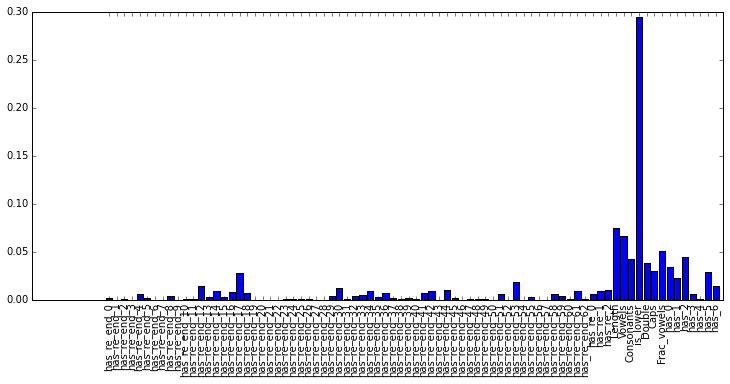

In [267]:
# Show feature importances
import pylab
import scipy

importances = rf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

labels = [cols[i] for i in indices.tolist()]
x = scipy.array(indices)
y = scipy.array(importances[indices])
f = pylab.figure(figsize=(12,5))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
f.show()

## 4. Make prediction 

In [292]:
rf = RandomForestClassifier(
                n_estimators=100,
                criterion='gini',
                oob_score=True,
                n_jobs=-1 )
rf.fit(train[cols], train['Label'])
submitRF = rf.predict_proba(test[cols])

In [293]:
submit = pd.DataFrame()
submit['Id'] = xrange(len(test))
submit['Answer'] = submitRF[:, 1]
submit[:5]

,Id,Answer
0,0,0.000000
1,1,0.001429
2,2,0.006207
3,3,0.006207
4,4,0.151481


In [294]:
submit.to_csv('submit.csv', index = False)